<a href="https://colab.research.google.com/github/elliot-linsey/KAN/blob/main/KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install pykan
import pandas as pd
from kan import KAN, create_dataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch

In [156]:
### let’s try this explicitly anyway
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
titanic_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
titanic = pd.read_csv(titanic_url)

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [123]:
X = pd.get_dummies(titanic, columns=['Sex'], dtype='float')
X = X[['Sex_female', 'Sex_male', 'Pclass']]
y = titanic[['Survived']]
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.25, random_state=42)

In [124]:
X_train

,Sex_female,Sex_male,Pclass
298,0.0,1.0,1
884,0.0,1.0,3
247,1.0,0.0,2
478,0.0,1.0,3
305,0.0,1.0,1
...,...,...,...
106,1.0,0.0,3
270,0.0,1.0,1
860,0.0,1.0,3
435,1.0,0.0,1


In [125]:
dataset = {}
dataset['train_input'] = torch.tensor(X_train.values)
dataset['test_input'] = torch.tensor(X_test.values)
dataset['train_label'] = torch.from_numpy(y_train.to_numpy()).reshape(668,1)
dataset['test_label'] = torch.from_numpy(y_test.to_numpy()).reshape(223,1)

In [157]:
model = KAN(width=[3,5,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));

train loss: 3.78e-01 | test loss: 3.82e-01 | reg: 1.59e+01 : 100%|██| 20/20 [00:02<00:00,  8.18it/s]


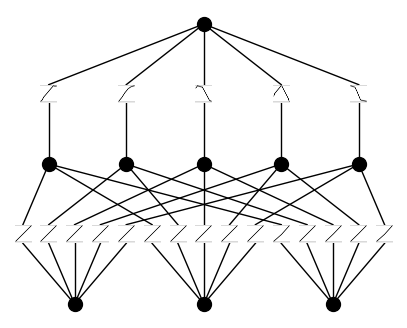

In [140]:
model.plot(beta=100)

In [152]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with exp, r2=1.0000000000000016
fixing (0,0,1) with exp, r2=1.0000000000000018
fixing (0,0,2) with exp, r2=1.0000000000000016
fixing (0,0,3) with x^4, r2=1.0000000000000016
fixing (0,0,4) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=1.0000000000000016
fixing (0,1,1) with exp, r2=1.0000000000000018
fixing (0,1,2) with x^4, r2=1.0000000000000018
fixing (0,1,3) with exp, r2=1.0000000000000018
fixing (0,1,4) with exp, r2=1.0000000000000013
fixing (0,2,0) with x^4, r2=0.9999999999997092
fixing (0,2,1) with tanh, r2=0.9999997449578547
fixing (0,2,2) with x^4, r2=0.9999999999997042
fixing (0,2,3) with exp, r2=0.9999999999974934
fixing (0,2,4) with x^4, r2=0.9999999999999971
fixing (1,0,0) with tanh, r2=0.9997007994014925
fixing (1,1,0) with tanh, r2=0.9999901693170681
fixing (1,2,0) with sin, r2=0.9998699344778729
fixing (1,3,0) with sin, r2=0.9994243180258627
fixing (1,4,0) with tanh, r2=0.9997604298539874


In [153]:
formula = model.symbolic_formula()[0][0]
formula

0.09*sin(0.06*(-x_1 - 0.81)**4 + 0.04*exp(2.71*x_2) + 21.37*exp(0.04*x_3) - 28.58) + 0.06*sin(0.34*(-x_2 - 0.67)**4 + 12.89*(-0.03*x_3 - 1)**4 + 0.02*exp(4.64*x_1) - 9.79) + 0.17*tanh(0.49*tanh(4.7*x_3 - 9.41) - 0.78) - 0.23*tanh(2.84*(-0.09*x_3 - 1)**4 + 0.09*exp(3.52*x_2) - 7.37) + 0.13*tanh(0.62*(-0.1*x_3 - 1)**4 + 0.17*exp(3.64*x_1) + 0.04*exp(4.03*x_2) - 4.85) + 0.39

In [154]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.7889)
test acc of the formula: tensor(0.7803)


In [155]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train.to_numpy().ravel())

# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test.to_numpy().ravel(), y_pred))

ACCURACY OF THE MODEL: 0.7847533632286996
